# TF Tau Finder

In [1]:
# fullwidth notebook cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# suppress tensorflow FutureWarning
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import h5py
import tensorflow as tf

# for reading & slicing data
import pandas as pd

# for data preprocessing
from sklearn.preprocessing import MinMaxScaler

import numpy as np

/Users/andrew/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/andrew/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/andrew/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/andrew/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


***

## Load data

In [3]:
data_path = 'wrap_data_test_1.csv'
data_df = pd.read_csv(data_path, dtype = float)

In [4]:
data_df.head()

,tau,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,4.263624,2.678914,2.681533,2.684151,2.686770,2.689389,2.692007,2.694626,2.697245,2.699863,...,-0.948926,-0.946307,-0.943688,-0.941069,-0.938451,-0.935832,-0.933213,-0.930595,-0.927976,-0.925357
1,30.689476,0.433210,0.452059,0.470909,0.489758,0.508607,0.527456,0.546306,0.565155,0.584004,...,0.696777,0.715627,0.734476,0.753325,0.772174,0.791024,0.809873,0.828722,0.847571,0.866421
2,77.284880,-1.705960,-1.658493,-1.611025,-1.563557,-1.516089,-1.468621,-1.421154,-1.373686,-1.326218,...,2.444055,2.491523,2.538990,2.586458,2.633926,2.681394,2.728861,2.776329,2.823797,2.871265
3,-21.807557,-1.135722,-1.149116,-1.162510,-1.175904,-1.189298,-1.202692,-1.216086,-1.229480,-1.242874,...,-2.150897,-2.164291,-2.177685,-2.191079,-2.204473,-2.217867,-2.231261,-2.244655,-2.258049,-2.271444
4,39.138534,-0.541275,-0.517237,-0.493198,-0.469159,-0.445121,-0.421082,-0.397044,-0.373005,-0.348967,...,-1.298898,-1.274859,-1.250820,-1.226782,-1.202743,-1.178705,-1.154666,-1.130628,-1.106589,-1.082550


### Seperate data into training and testing

In [5]:
# Randomly sample 80%
training_data_df = data_df.sample(frac = 0.8)

In [6]:
testing_data_df = data_df.loc[~data_df.index.isin(training_data_df.index)]

#### Truncate data for experimentation

In [7]:
training_short_df = training_data_df.loc[:, :'1023']

In [8]:
testing_short_df = testing_data_df.loc[:, :'1023']

### Split the data into X and Y

In [9]:
# drop the tau column from the X data (data to train with)
# axis = 1 drops the column
X_training = training_short_df.drop('tau', axis = 1).values

# retain only the tau column (value to predict) for the Y data
Y_training = training_short_df[['tau']].values

In [10]:
# drop the tau column from the X data (data to train with)
# axis = 1 drops the column
X_testing = testing_short_df.drop('tau', axis = 1).values

# retain only the tau column (value to predict) for the Y data
Y_testing = testing_short_df[['tau']].values

In [11]:
# Create scalars for inputs and outputs
X_scaler = MinMaxScaler(feature_range = (0,1))
Y_scaler = MinMaxScaler(feature_range = (0,1))

In [12]:
# Scale training input and output
X_scaled_training = X_scaler.fit_transform(X_training)
Y_scaled_training = Y_scaler.fit_transform(Y_training)

In [13]:
# Scale testing data using same scaler
X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)

In [14]:
X_scaled_training.shape

(8000, 1024)

In [15]:
msg = 'Note: Y values were scaled by multiplying by {:.10f} and adding {:.4f}'
print(msg.format(Y_scaler.scale_[0], Y_scaler.min_[0]))

Note: Y values were scaled by multiplying by 0.0050027049 and adding 0.4997


In [16]:
# Define how many inputs and outputs are in our neural network
number_of_inputs = X_scaled_training.shape[1]
number_of_outputs = Y_scaled_training.shape[1]

In [17]:
# define how many neurons we want in each layer of our NN
layer_1_nodes = 20
layer_2_nodes = 500
layer_3_nodes = 50

In [18]:
# Define model parameters
learning_rate = 0.001
training_epochs = 100
display_step = 2

In [19]:
# Input Layer
with tf.variable_scope('input'):
    X  = tf.placeholder(tf.float32, shape = (None, number_of_inputs))
    
# Layer 1
with tf.variable_scope('layer_1'):
    
    biases = tf.get_variable(name = "biases1",
                             shape = [layer_1_nodes],
                             initializer = tf.zeros_initializer())
    
    weights = tf.get_variable(name = "weights1",
                              shape  = [number_of_inputs, layer_1_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_1_output = tf.nn.relu(tf.matmul(X, weights) + biases)
    
# Layer 2
with tf.variable_scope('layer_2'):
    
    biases = tf.get_variable(name = "biases2",
                             shape = [layer_2_nodes],
                             initializer = tf.zeros_initializer())
    
    weights = tf.get_variable(name = "weights2",
                              shape  = [layer_1_nodes, layer_2_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_2_output = tf.nn.relu(tf.matmul(layer_1_output, weights) + biases)
    
# Layer 3
with tf.variable_scope('layer_3'):
    
    biases = tf.get_variable(name = "biases3",
                             shape = [layer_3_nodes],
                             initializer = tf.zeros_initializer())
    
    weights = tf.get_variable(name = "weights3",
                              shape  = [layer_2_nodes, layer_3_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)
    
# Output layer

with tf.variable_scope('output'):
    
    biases = tf.get_variable(name = "biases_out",
                             shape = [number_of_outputs],
                             initializer = tf.zeros_initializer())
    
    weights = tf.get_variable(name = "weights_out",
                              shape  = [layer_3_nodes, number_of_outputs],
                         initializer = tf.contrib.layers.xavier_initializer())


    prediction = tf.nn.relu(tf.matmul(layer_3_output, weights) + biases)
    
with tf.variable_scope('cost'):
    
    Y = tf.placeholder(tf.float32, shape = (None, 1))
    cost = tf.reduce_mean(tf.squared_difference(prediction, Y))

    
with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-05).minimize(cost)
    
with tf.variable_scope('logging'):
    tf.summary.scalar('current_cost', cost)
    summary = tf.summary.merge_all()
    
saver = tf.train.Saver()

/Users/andrew/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [20]:
# initialize a session to run TF operations
with tf.Session() as session:
    
    # Run the global variable initilizer to init all variables and layers
    session.run(tf.global_variables_initializer())
    
    # Create log writers to record training progress
    # Store training and testing data separately
    training_writer = tf.summary.FileWriter('logs3/training', session.graph)
    testing_writer = tf.summary.FileWriter('logs3/testing', session.graph)
    
    
    # Run the optimizer over and over to train the network
    # One epoch is one full run through the training data set
    for epoch in range(training_epochs):
        
        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training, Y: Y_scaled_training})

        # Every display_step steps, log our process
        if epoch % display_step == 0:
            
            training_feed = {X: X_scaled_training, Y: Y_scaled_training}
            training_cost, training_summary = session.run([cost, summary],
                                                    feed_dict = training_feed)
            
            testing_feed =  {X: X_scaled_testing, Y: Y_scaled_testing}
            testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)
            
            print(epoch, training_cost, testing_cost)
            
            # write the current status to the log files
            training_writer.add_summary(training_summary, epoch)
            testing_writer.add_summary(testing_summary, epoch)
            
    print('Training done')
    
    final_training_cost = session.run(cost,
                                      feed_dict = {X: X_scaled_training,
                                                   Y: Y_scaled_training})
    
    final_testing_cost = session.run(cost,
                                     feed_dict = {X: X_scaled_testing,
                                                  Y: Y_scaled_testing})

    print('Final Training Cost: {}'.format(final_training_cost))
    print('Final Testing Cost: {}'.format(final_testing_cost))
    
    
    # Now that the NN is trained, lets use it to make predictions.
    # pass in the X testing data and run the prediction operation
    Y_prediction_scaled = session.run(prediction,
                                      feed_dict = {X:X_scaled_testing})

    # Unscale the data back to its original units (dollar$)
    Y_predicted = Y_scaler.inverse_transform(Y_prediction_scaled)
    
    rand_entry = np.random.randint(0,200)
    # actual earnings of 0th game
    real_tau = testing_short_df['tau'].values[rand_entry]
    
    # predicted_earnings of 0th game
    predicted_earnings = Y_predicted[rand_entry][0]
    
    print('The actual tau of row #1 is {}'.format(real_tau))
    
    msg = 'The predicted tau of row #1 is {}'
    print(msg.format(predicted_earnings))
    
    model_save_location = "logs3/trained_model.ckpt"
    save_path = saver.save(session, model_save_location)
    print('Model saved: {}'.format(save_path))

0 0.12384813 0.12551996
2 0.10278259 0.10108135
4 0.10479634 0.106163315
6 0.093287475 0.09393341
8 0.09648123 0.09463333
10 0.08785094 0.087537244
12 0.09025907 0.09092345
14 0.08724412 0.08753214
16 0.088768326 0.08823479
18 0.08611495 0.086101666
20 0.08694216 0.08742212
22 0.085516974 0.08571994
24 0.08596465 0.08588068
26 0.08481713 0.08512972
28 0.08474254 0.08535362
30 0.08406742 0.084535
32 0.083616436 0.08411285
34 0.083268635 0.08412484
36 0.082586914 0.083529875
38 0.08203473 0.0829691
40 0.08164421 0.08276111
42 0.08091142 0.08217886
44 0.08009504 0.08138021
46 0.07920088 0.08073125
48 0.07833832 0.079851605
50 0.077375636 0.07906579
52 0.07643496 0.07803444
54 0.075346 0.0770887
56 0.07433203 0.07601981
58 0.07321315 0.074921645
60 0.07212069 0.073917836
62 0.07104653 0.07293193
64 0.0699175 0.071860865
66 0.06883702 0.07087055
68 0.06796067 0.070070654
70 0.067008965 0.069709964
72 0.065525174 0.067888655
74 0.06413298 0.06693757
76 0.063073166 0.065799646
78 0.061656877 

In [21]:
real_tau_ten = testing_short_df['tau'].values[0:10]
predicted_earnings_ten = Y_predicted[0:10].T[0]
print(real_tau_ten)
print(predicted_earnings_ten)

[ 77.2848799   82.53084872 -46.78979372   8.3500292   76.53500637
  91.87107739  58.73071152 -54.44329068 -87.52381841  55.44658825]
[-15.719983    9.929435  -25.000648    4.4912586   1.7812501  96.035706
  11.3358555 -30.760336  -14.717987    7.0561733]


In [22]:
import matplotlib.pyplot as plt

In [23]:
sort_idx = np.argsort(testing_short_df['tau'].values)

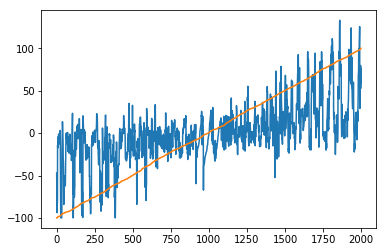

In [29]:
plt.plot(Y_predicted[:].T[0][sort_idx][::])
plt.plot(testing_short_df['tau'].values[sort_idx][::])
plt.show()

In [25]:
Y_predicted[:].T.shape

(1, 2000)

In [26]:
import matplotlib.pyplot as plt

In [27]:
Y_predicted.shape

(2000, 1)

In [28]:
.shape

SyntaxError: invalid syntax (<ipython-input-28-abefa8d9bb1a>, line 1)